In [1]:
DATA_DIR = "benchmark-multi-gpu-nthreads-scratch"

In [2]:
%matplotlib inline

In [3]:
XFER_TYPE_MAPPING = {
        0: "Storage->GPU (GDS)",
        1: "Storage->CPU",
        2: "Storage->CPU->GPU",
#         3: "Storage->CPU->GPU_ASYNC",
# #         4: "Storage->PAGE_CACHE->CPU->GPU",
#         5: "Storage->GPU_ASYNC",
#         6: "Storage->GPU_BATCH" # Experiments failed
    }

In [4]:
OPERATION_TYPE_MAPPING = {
        0: "read",
        1: "write",
        2: "randread",
        3: "randwrite"
    }

In [5]:
xfer_types_to_skip = set(range(7)).difference(XFER_TYPE_MAPPING)
print(xfer_types_to_skip)

{3, 4, 5, 6}


In [6]:
threads_to_skip = {2}

# Throughput and latency

In [7]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

In [8]:
def parse_xfer_type(type_):
    return XFER_TYPE_MAPPING[int(type_)]

In [9]:
def parse_operation_type(type_):
    return OPERATION_TYPE_MAPPING[int(type_)]

In [10]:
params_path_pattern = r"benchmark-(\d+)-(\d+)-([^-]+)-(\d+)-([01])-" # "benchmark-$X-${NUM_GPUS}-$RW-$W-${ENABLE_NVLINKS}-${SLURM_JOB_ID}"
results_pattern = r"Throughput: ([^\s]+) GiB/sec, Avg_Latency: ([^\s]+) usecs"

measurements = []

pathlist = Path(DATA_DIR).glob('slurm-benchmark-*.out')

for path in pathlist:
    with open(path, "r") as f:
        content = f.read()
    slurm_job_id = re.search(r"slurm-benchmark-(\d+).out", str(path)).group(1)

    results_dir = next(Path(DATA_DIR).glob(f"benchmark-*-{slurm_job_id}"))

    params_match = re.search(params_path_pattern, str(results_dir))
    results_match = re.search(results_pattern, content)
    if int(params_match.group(1)) in xfer_types_to_skip:
        continue
    if (threads := int(params_match.group(4))) in threads_to_skip:
        continue
    
    measurements.append({
        "xfer_type": parse_xfer_type(params_match.group(1)),
        "num_gpus": int(params_match.group(2)),
        "op_type": params_match.group(3),
        "threads": threads,
        "nvlink": params_match.group(5) == "1",
        "throughput (GiB/sec)": float(results_match.group(1)),
        "latency (usecs)": float(results_match.group(2))
    })

measurements_df = pd.DataFrame(measurements)

In [11]:
measurements_df["xfer_type"] = measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
measurements_df["op_type"] = measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)

from itertools import product

measurements_df["grp"] = (measurements_df.xfer_type.astype('str') + ', nvlink=' + measurements_df.nvlink.astype('str')).astype(
    CategoricalDtype(categories=list(x + ', nvlink=' + y for x, y in product(measurements_df.xfer_type.cat.categories, ["False", "True"])), ordered=True)
)

In [12]:
measurements_df

,xfer_type,num_gpus,op_type,threads,nvlink,throughput (GiB/sec),latency (usecs),grp
0,Storage->GPU (GDS),8,write,8,True,8.459751,7386.973306,"Storage->GPU (GDS), nvlink=True"
1,Storage->CPU->GPU,2,read,16,False,15.044443,2077.153122,"Storage->CPU->GPU, nvlink=False"
2,Storage->CPU,1,read,8,False,5.629459,1387.809080,"Storage->CPU, nvlink=False"
3,Storage->GPU (GDS),2,write,4,False,4.303721,1815.776741,"Storage->GPU (GDS), nvlink=False"
4,Storage->GPU (GDS),8,randread,4,True,14.160072,2207.237487,"Storage->GPU (GDS), nvlink=True"
...,...,...,...,...,...,...,...,...
331,Storage->CPU->GPU,2,write,32,True,8.934308,7022.366235,"Storage->CPU->GPU, nvlink=True"
332,Storage->CPU,1,read,4,True,2.958477,1320.416844,"Storage->CPU, nvlink=True"
333,Storage->GPU (GDS),1,write,32,True,4.600403,6845.044507,"Storage->GPU (GDS), nvlink=True"
334,Storage->CPU,1,write,8,False,5.382358,1451.562379,"Storage->CPU, nvlink=False"


# W tym przypadku nie ma dużych różnic między NVLink=False i True, są niewielkie i mogły wynikać z błędu pomiaru po prostu

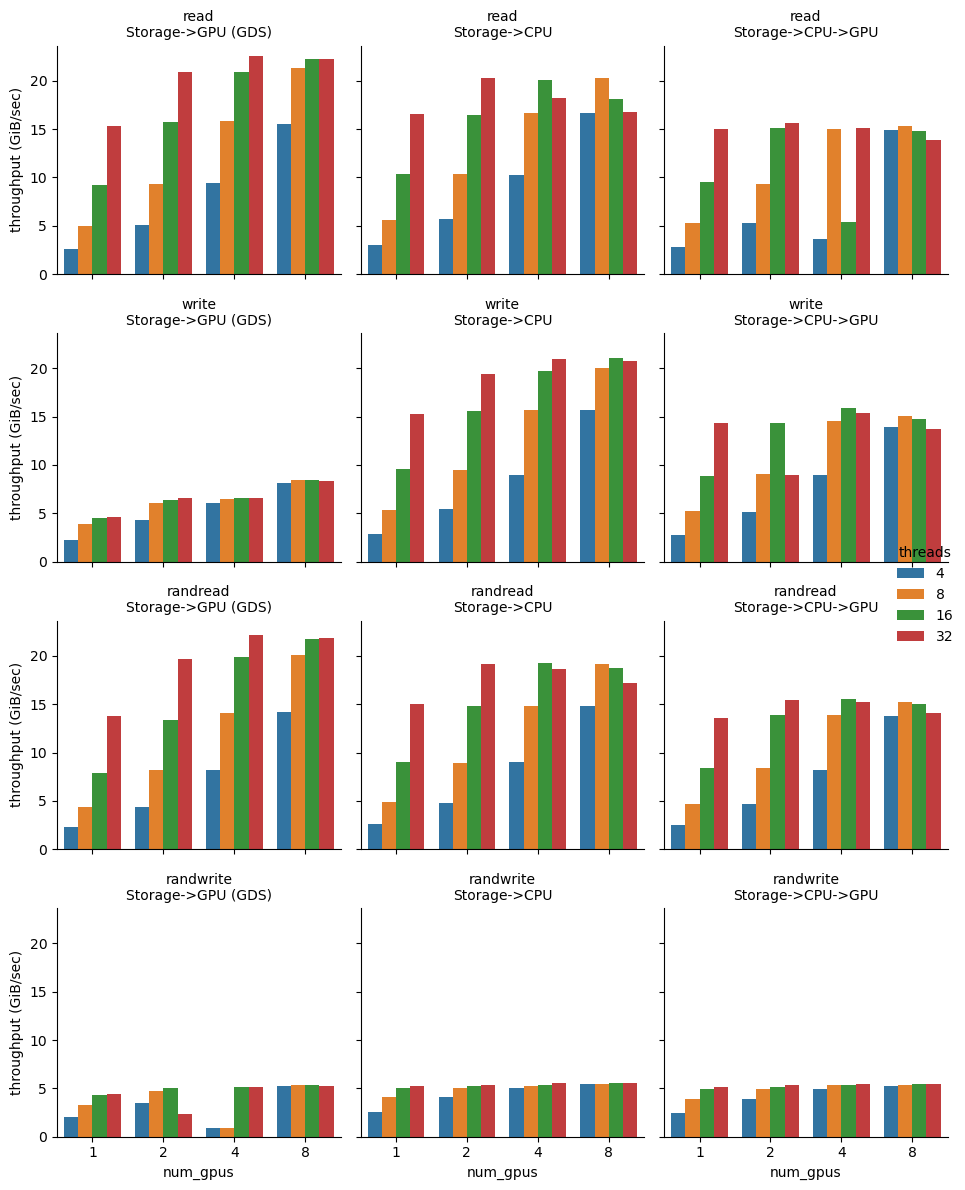

In [13]:
g = sns.FacetGrid(measurements_df[measurements_df.nvlink], col="xfer_type", row="op_type")
g.set_titles("{row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="num_gpus", y="throughput (GiB/sec)", hue="threads",
    palette=sns.color_palette(n_colors=measurements_df.threads.nunique())
)
g.add_legend(title="threads")
# for ax in g.axes_dict.values():
#     for cnt in ax.containers:
#         for bar in cnt:
#             bar.set_alpha(0.2)

plt.tight_layout()
plt.savefig(f"img/{DATA_DIR}/throughput-dgx-4-scratch.jpg", dpi='figure')
plt.show()